# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project: Analysis Of Labelled Faces in the Wild (LFW) Dataset

GitHub: https://github.com/ilichenko/DTSA-5510

## I. Introduction
This study examines the application of unsupervised machine learning techniques to analyze Labeled Faces in the Wild (LFW) dataset. In particular, we will focus on the performance of models built using the k-Nearest Neighbors (kNN) classifier. In addition, the study investigates and compares dimensionality reduction methods - Principal Component Analysis (PCA) and Non-Negative Matrix Factorization (NMF). In order to identify their impact on model performance, kNN is again applied on compressed data.

## II. Dataset

Labeled Faces in the Wild (LFW) is a dataset containing pictures of faces collected specifically to study the problem of unconstrained face recognition. It includes more than 13,000 images of famous personalities and each face in this dataset has been labeled with the name of the person in the image. For this analysis, the dataset will be loaded using fetch_lfw_people Loader. 

## III. Exploratory Data Analysis
The following code installs the required libraries and imports the raw LFW data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import NMF, PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate

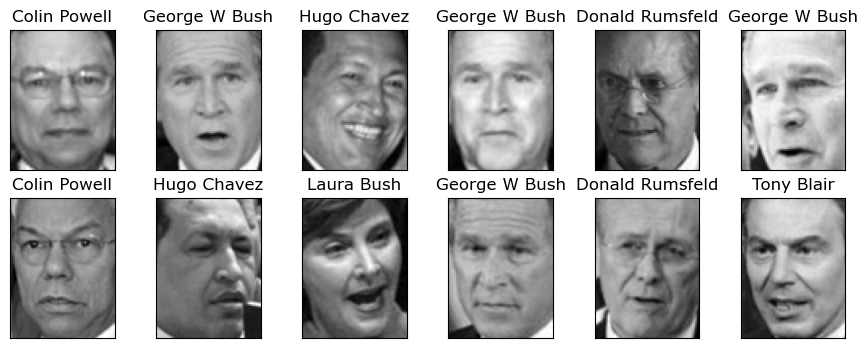

In [2]:
people = fetch_lfw_people(min_faces_per_person=35, resize=0.7)

image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 6, figsize=(11, 4),
                        subplot_kw={'xticks': (), 'yticks': ()}
                        )

for target, image, ax in zip(people.target, people.images, axes.ravel()): # axes.ravel() used to flatten into a 1-dim array
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

We have imported above only images of people with minimum number of images in the dataset equal to 35. We now analyze the images of the remaining individuals for outliers. As shown below, the dataset does contain 530 images of George Bush, 236 images of Colin Powell, 144 images of Tony Blair, 121 images of Donald Rumsfeld and 109 images of Gerhard Schröder, which will lead to overloading of the feature extraction by the above mentioned personalities' images, and consequently may negatively affect the results of our study. 

Since the average image count for each individual is 86, we next limit the maximum number of images for each personality to 86. The resulting ascending sorted counts are presented below.

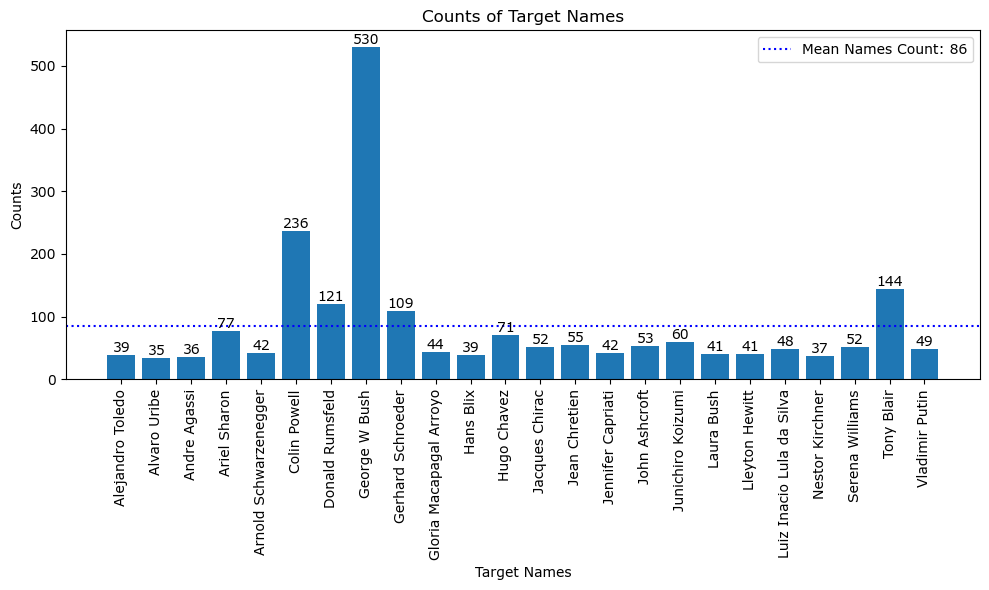

In [3]:
counts = np.bincount(people.target)
target_names = people.target_names
rounded_mean = round(np.mean(counts))

plt.figure(figsize=(10, 6))
bars = plt.bar(target_names, counts)
plt.xticks(rotation=90)
plt.axhline(rounded_mean, color='blue', linestyle='dotted', label=f'Mean Names Count: {rounded_mean}')
plt.xlabel('Target Names')
plt.ylabel('Counts')
plt.title('Counts of Target Names')
plt.legend()
plt.tight_layout()

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.show()

In [4]:
mask = np.zeros(people.target.shape, dtype=bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:86]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, random_state=42)

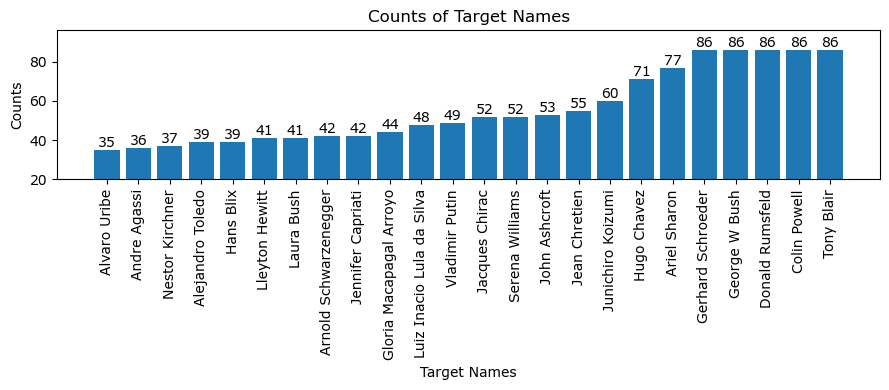

In [5]:
counts = np.bincount(y_people)
sorted_indices = np.argsort(counts)
sorted_counts = counts[sorted_indices]

target_names = people.target_names
sorted_names = target_names[sorted_indices]

plt.figure(figsize=(9, 4))
bars = plt.bar(sorted_names, sorted_counts)
plt.xticks(rotation=90)
plt.xlabel('Target Names')
plt.ylabel('Counts')
plt.title('Counts of Target Names')
plt.tight_layout()
plt.ylim(20, max(sorted_counts) + 10)


# Add counts as numbers near each bar
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.show()

In this way, we have obtained a relatively equal number of images for each of the 24 remaining individuals, and can use this data to build models.

## IV. Main Study

### 4.1. kNN Models

Using the function below, we will train the kNN classifier from 1 to 100 neighbors on the training data, then calculate the maximum accuracies achieved by the model and plot the accuracies of all models on a graph. 

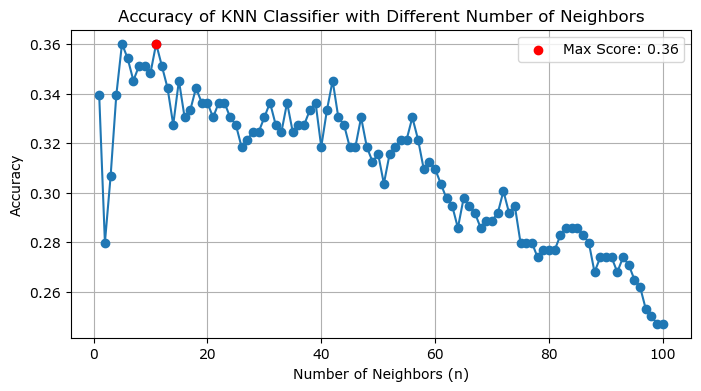

Maximum accuracy score = 0.36 for n_neighbors = 11


(0.3601190476190476, 11)

In [6]:
def get_best_knn_acc(x_train, x_test, n_iter, plot):
    scores = []
    for n in range(1, n_iter+1):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(x_train, y_train)
        
        score = knn.score(x_test, y_test)
        scores.append((score, n))
    
    max_score, best_n = max(scores)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot([n for _, n in scores], [score for score, _ in scores], marker='o', linestyle='-')
        plt.xlabel('Number of Neighbors (n)')
        plt.ylabel('Accuracy')
        plt.title('Accuracy of KNN Classifier with Different Number of Neighbors')
        plt.grid(True)
        
        plt.scatter(best_n, max_score, color='red', label=f'Max Score: {max_score:.2f}', zorder=10)
        plt.legend()
        plt.show()
    
    print(f'Maximum accuracy score = {max_score:.2f} for n_neighbors = {best_n}')
    return max_score, best_n

get_best_knn_acc(X_train, 
                 X_test, 
                 100, 
                 True)

From the output, we can see that the highest accuracies were achieved using 11 neighbors and amounts to 0.36. Since the result is not impressive, we proceed with dimensionality reduction in the next step. 

### 4.2 Dimensionality Reduction Using PCA

The next function calculates the training and test values obtained after applying Principal Component Analysis. 
Next, we depict the first 50 components. 

In [7]:
def build_pca(x_train, x_test, n_components, whiten):
    pca = PCA(n_components=n_components, whiten=whiten, random_state=42)#.fit(X_train)
    X_train_pca = pca.fit_transform(x_train)
    X_test_pca = pca.transform(x_test)
    return pca, X_train_pca, X_test_pca

pca, _, _ = build_pca(X_train, 
                      X_test, 
                      50, 
                      True)

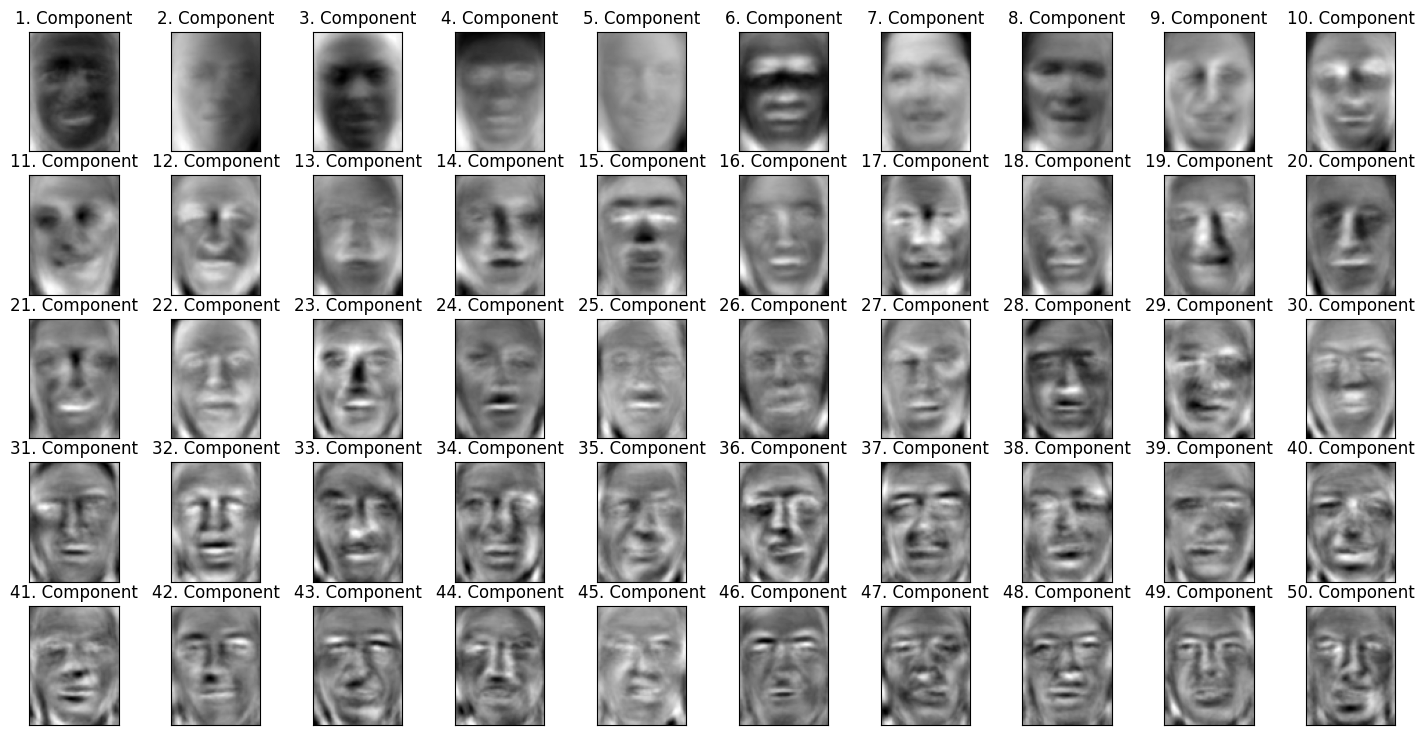

In [92]:
fig, axes = plt.subplots(5, 10, figsize=(18, 9), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel()), start=1):
    component_image = component.reshape(image_shape) # reshape component to match image shape
    ax.imshow(component_image, cmap='gray') # display component as an image
    ax.set_title(f'{i}. Component')

We conclude this section by illustrating an example of applying PCA for different numbers of components. 

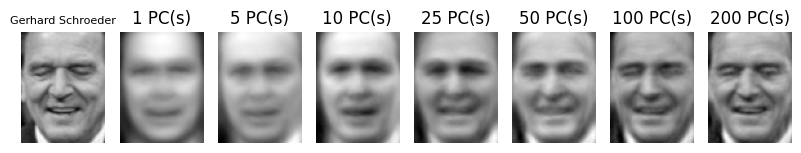

In [93]:
random_pic = X_train[3]
n_components_values = [1, 5, 10, 25, 50, 100, 200]
reconstructions = []

for n_components in n_components_values:
    
    pca, _, _, = build_pca(X_train, X_test, n_components, True)
    
    transformed_pic = pca.transform(random_pic.reshape(1, -1))
    reconstructed_pic = pca.inverse_transform(transformed_pic)
    reconstructions.append(reconstructed_pic)

plt.figure(figsize=(8, 3))
plt.subplot(1, len(n_components_values)+1, 1)
plt.imshow(random_pic.reshape(image_shape), cmap='gray')
plt.title(people.target_names[y_train[3]], fontsize=8)
plt.axis('off')

for i, n_components in enumerate(n_components_values):
    plt.subplot(1, len(n_components_values)+1, i+2)
    plt.imshow(reconstructions[i].reshape(image_shape), cmap='gray')
    plt.title(f'{n_components} PC(s)')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4.3. kNN Models On Data Compressed By PCA

We will then calculate the accuracy of our kNN models on the PCA-compressed data. We start with 10 components and increase the step by 5 until we reach 100 components. 

In [94]:
n_components_values = list(range(10, 101, 5))

best_max_score_pca, best_best_n_pca = 0, 0
best_X_train_pca, best_X_test_pca = None, None
for n_components in n_components_values:
    pca, X_train_pca, X_test_pca, = build_pca(X_train, X_test, n_components, True)
    print(f'Number of PCA componens = {n_components}')
    max_score_pca, best_n_pca = get_best_knn_acc(X_train_pca, 
                                                 X_test_pca, 
                                                 100, 
                                                 False)
    if max_score_pca > best_max_score_pca:
        best_max_score_pca = max_score_pca
        best_best_n_pca = best_n_pca
        best_n_components_pca = n_components
        best_X_train_pca = X_train_pca
        best_X_test_pca = X_test_pca
print(f'\nBest maximum accuracy score = {round(best_max_score_pca, 2)} with {best_n_components_pca} components.')

Number of PCA componens = 10
Maximum accuracy score = 0.31 for n_neighbors = 34
Number of PCA componens = 15
Maximum accuracy score = 0.36 for n_neighbors = 17
Number of PCA componens = 20
Maximum accuracy score = 0.42 for n_neighbors = 15
Number of PCA componens = 25
Maximum accuracy score = 0.42 for n_neighbors = 34
Number of PCA componens = 30
Maximum accuracy score = 0.45 for n_neighbors = 25
Number of PCA componens = 35
Maximum accuracy score = 0.49 for n_neighbors = 15
Number of PCA componens = 40
Maximum accuracy score = 0.49 for n_neighbors = 21
Number of PCA componens = 45
Maximum accuracy score = 0.49 for n_neighbors = 21
Number of PCA componens = 50
Maximum accuracy score = 0.50 for n_neighbors = 15
Number of PCA componens = 55
Maximum accuracy score = 0.49 for n_neighbors = 12
Number of PCA componens = 60
Maximum accuracy score = 0.49 for n_neighbors = 21
Number of PCA componens = 65
Maximum accuracy score = 0.48 for n_neighbors = 23
Number of PCA componens = 70
Maximum acc

We can see that the result increased from 0.36 to 0.51 and we needed 7 neighbors instead of 11. Next, we will present examples of correctly classified labels as well as false negative and false positive predictions using George W. Bush as an example. 

Examples for correct (1st row), false negative (2nd row) and false positive (3rd row) predictions:


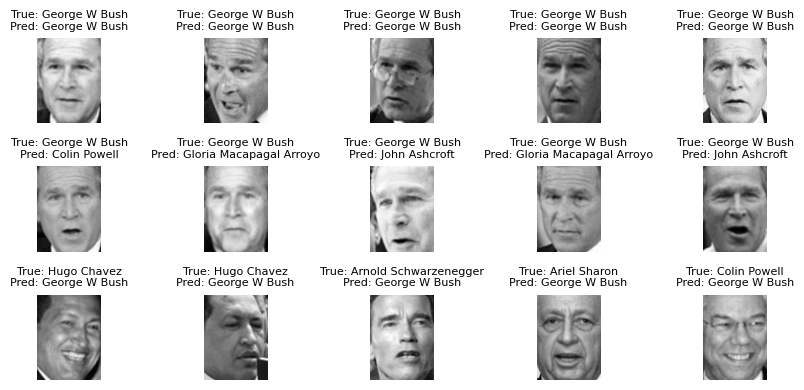

In [95]:
knn = KNeighborsClassifier(n_neighbors=best_best_n_pca)
knn.fit(best_X_train_pca, y_train)

y_pred_pca = knn.predict(best_X_test_pca)

plt.figure(figsize=(9, 4))

correct_images, fn_images, fp_images = [], [], []
correct_count, fn_count, fp_count = 0, 0, 0

for image, true_label, pred_label in zip(X_people, y_people, y_pred_pca):
    if true_label == pred_label and people.target_names[true_label] == 'George W Bush':
        correct_count += 1
        if correct_count <= 5:
            correct_images.append((image, true_label, pred_label))
    elif people.target_names[true_label] == 'George W Bush':
        fn_count += 1
        if fn_count <= 5:
            fn_images.append((image, true_label, pred_label))
    elif people.target_names[pred_label] == 'George W Bush':
        fp_count += 1
        if fp_count <= 5:
            fp_images.append((image, true_label, pred_label))

print("Examples for correct (1st row), false negative (2nd row) and false positive (3rd row) predictions:")
for i, (image, true_label, pred_label) in enumerate(correct_images):
    plt.subplot(3, 5, i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')

for i, (image, true_label, pred_label) in enumerate(fn_images):
    plt.subplot(3, 5, 5+i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')

for i, (image, true_label, pred_label) in enumerate(fp_images):
    plt.subplot(3, 5, 10+i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')
    
plt.tight_layout()
plt.show()


To conclude the PCA analysis, we will generate a Confusion Matrix. 

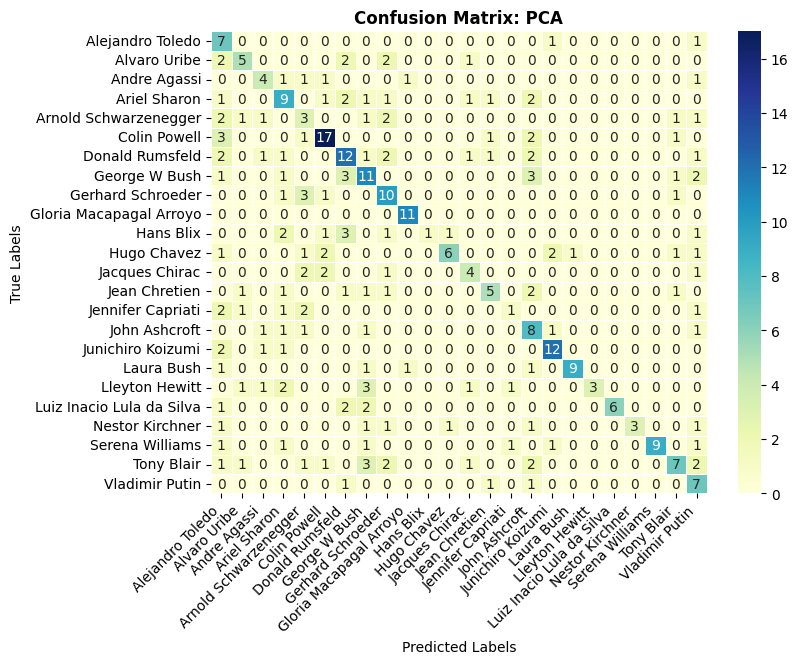

In [124]:
conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Confusion Matrix: PCA', weight='bold')
sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, ax=ax)
ax.set_xticks(np.arange(len(target_names)) + 0.5)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_yticks(np.arange(len(target_names)) + 0.5)
ax.set_yticklabels(target_names, rotation=0)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

From the results, we see that the vast majority of people have more correct predictions than incorrect predictions. Moreover there are no zero elements on the main diagonal. 

### 4.4 Dimensionality Reduction Using NMF

In analogy with the PCA analysis, the following function calculates the training and test values obtained after applying NMF. 
In the following, we again depict the first 50 components. 

In [8]:
def build_nmf(x_train, x_test, n_components):
    nmf = NMF(n_components=n_components, random_state=42)
    nmf.fit(X_train)
    X_train_nmf = nmf.transform(X_train) # W_train
    X_test_nmf = nmf.transform(X_test)
    return nmf, X_train_nmf, X_test_nmf

nmf, _, _ = build_nmf(X_train, 
                      X_test, 
                      50)

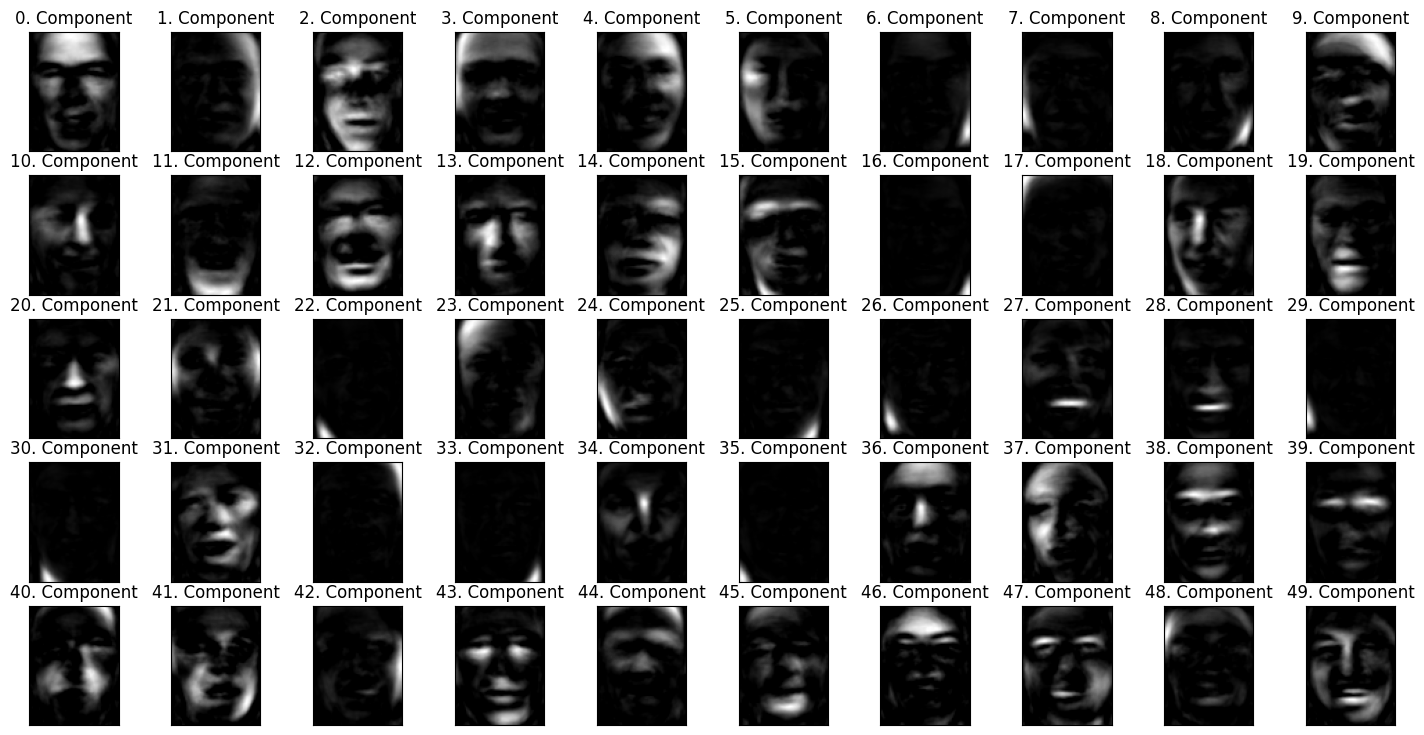

In [99]:
fig, axes = plt.subplots(5, 10, figsize=(18, 9), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel()), start=0):
    component_image = component.reshape(image_shape) # reshape component to match image shape
    ax.imshow(component_image, cmap='gray') # display component as an image
    ax.set_title(f'{i}. Component')

To conclude this section, we will illustrate an example of applying NMF for different numbers of components and obtain very similar results. 

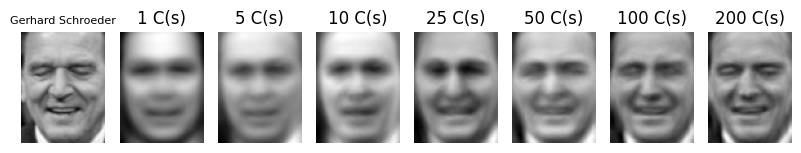

In [100]:
random_pic = X_train[3]
n_components_values = [1, 5, 10, 25, 50, 100, 200]
reconstructions = []

for n_components in n_components_values:
    
    nmf, _, _, = build_nmf(X_train, X_test, n_components)
    H = nmf.components_
    
    transformed_pic = nmf.transform(random_pic.reshape(1, -1))
    reconstructed_pic = np.dot(transformed_pic, H)
    reconstructions.append(reconstructed_pic)

plt.figure(figsize=(8, 3))
plt.subplot(1, len(n_components_values)+1, 1)
plt.imshow(random_pic.reshape(image_shape), cmap='gray')
plt.title(people.target_names[y_train[3]], fontsize=8)
plt.axis('off')

for i, n_components in enumerate(n_components_values):
    plt.subplot(1, len(n_components_values)+1, i+2)
    plt.imshow(reconstructions[i].reshape(image_shape), cmap='gray')
    plt.title(f'{n_components} C(s)')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4.5. kNN Models On Data Compressed By NMF

We will then calculate the accuracy of our kNN models on the data compressed using NMF. Here again we will start with 10 components and increase the step by 5 until we reach 100 components. 

In [101]:
n_components_values = list(range(10, 101, 5))
best_max_score_nmf, best_best_n_nmf = 0, 0
best_W_train, best_W_test = None, None
for n_components in n_components_values:
    nmf, W_train, W_test, = build_nmf(X_train, X_test, n_components)
    print(f'Number of NMF componens = {n_components}')
    max_score_nmf, best_n_nmf = get_best_knn_acc(W_train, 
                                                 W_test, 
                                                 100, 
                                                 False)
    if max_score_nmf > best_max_score_nmf:
        best_max_score_nmf = max_score_nmf
        best_best_n_nmf = best_n_nmf
        best_n_components_nmf = n_components
        best_W_train = W_train
        best_W_test = W_test
print(f'\nBest maximum accuracy score = {round(best_max_score_nmf, 2)} with {best_n_components_nmf} components.')

Number of NMF componens = 10
Maximum accuracy score = 0.26 for n_neighbors = 36
Number of NMF componens = 15
Maximum accuracy score = 0.24 for n_neighbors = 22
Number of NMF componens = 20
Maximum accuracy score = 0.27 for n_neighbors = 12
Number of NMF componens = 25
Maximum accuracy score = 0.24 for n_neighbors = 42
Number of NMF componens = 30
Maximum accuracy score = 0.25 for n_neighbors = 53
Number of NMF componens = 35
Maximum accuracy score = 0.24 for n_neighbors = 11
Number of NMF componens = 40
Maximum accuracy score = 0.24 for n_neighbors = 15
Number of NMF componens = 45
Maximum accuracy score = 0.24 for n_neighbors = 60
Number of NMF componens = 50
Maximum accuracy score = 0.25 for n_neighbors = 50
Number of NMF componens = 55
Maximum accuracy score = 0.25 for n_neighbors = 13
Number of NMF componens = 60
Maximum accuracy score = 0.27 for n_neighbors = 11
Number of NMF componens = 65
Maximum accuracy score = 0.22 for n_neighbors = 9
Number of NMF componens = 70
Maximum accu

In this case, we can conclude that the result has decreased compared to the original one, namely from 0.36 to 0.27. Nevertheless, it is interesting to observe examples of both correct and incorrect classification for George Bush in analogy with PCA.  

Examples for correct (1st row), false negative (2nd row) and false positive (3rd row) predictions:


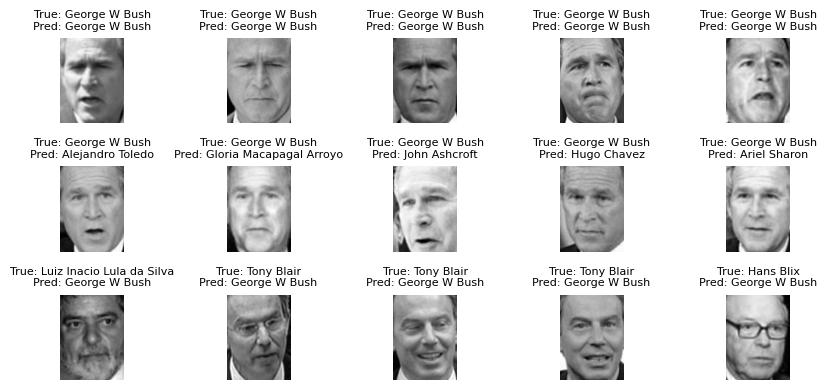

In [105]:
knn = KNeighborsClassifier(n_neighbors=best_best_n_nmf)
knn.fit(best_W_train, y_train)

y_pred_nmf = knn.predict(best_W_test)

plt.figure(figsize=(9, 4))

correct_images, fn_images, fp_images = [], [], []
correct_count, fn_count, fp_count = 0, 0, 0

for image, true_label, pred_label in zip(X_people, y_people, y_pred_nmf):
    if true_label == pred_label and people.target_names[true_label] == 'George W Bush':
        correct_count += 1
        if correct_count <= 5:
            correct_images.append((image, true_label, pred_label))
    elif people.target_names[true_label] == 'George W Bush':
        fn_count += 1
        if fn_count <= 5:
            fn_images.append((image, true_label, pred_label))
    elif people.target_names[pred_label] == 'George W Bush':
        fp_count += 1
        if fp_count <= 5:
            fp_images.append((image, true_label, pred_label))

print("Examples for correct (1st row), false negative (2nd row) and false positive (3rd row) predictions:")
for i, (image, true_label, pred_label) in enumerate(correct_images):
    plt.subplot(3, 5, i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')

for i, (image, true_label, pred_label) in enumerate(fn_images):
    plt.subplot(3, 5, 5+i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')

for i, (image, true_label, pred_label) in enumerate(fp_images):
    plt.subplot(3, 5, 10+i+1)
    plt.imshow(image.reshape(people.images.shape[1:]), cmap='gray')
    plt.title(f'True: {people.target_names[true_label]}\nPred: {people.target_names[pred_label]}', fontsize=8)
    plt.axis('off')
    
plt.tight_layout()
plt.show()


To conclude the NMF analysis, we will plot a Confusion Matrix. 

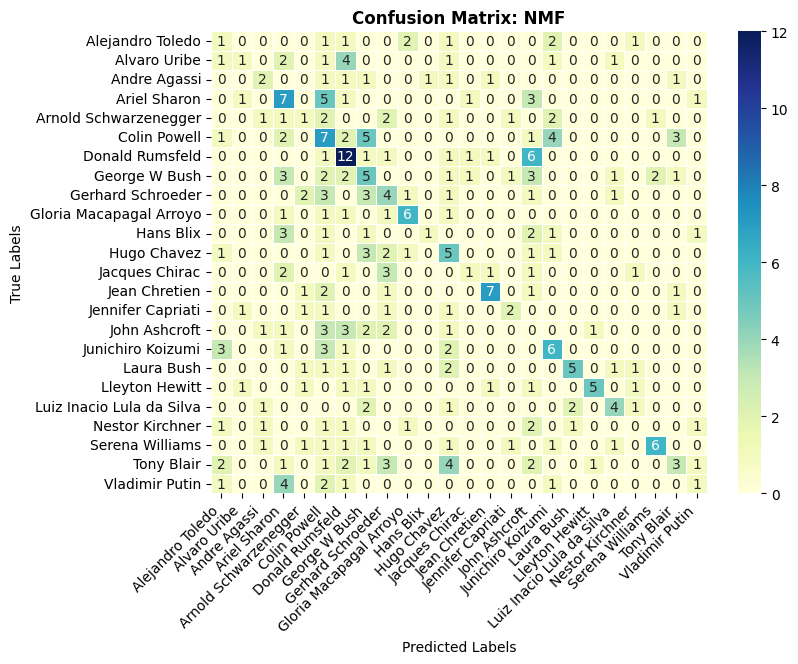

In [122]:
conf_matrix_nmf = confusion_matrix(y_test, y_pred_nmf)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Confusion Matrix: NMF', weight='bold')
sns.heatmap(conf_matrix_nmf, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, ax=ax)
ax.set_xticks(np.arange(len(target_names)) + 0.5)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.set_yticks(np.arange(len(target_names)) + 0.5)
ax.set_yticklabels(target_names, rotation=0)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

As we expected based on the accuracy value, the NMF predictions are much worse than those of PCA, for example here there are even zero elements on the main diagonal. 

## V. Conclusion

In this study, we compared the two dimensionalality reduction methods, finding that PCA performed better than NMF for our set-up, and applied the kNN classifier to train and evaluate the performance of the models. In the future, it would be interesting to compare the obtained accuracy values with the best value for supervised machine learning algorithms (e.g., Support Vector Machines) as well as Neural Networks with different input parameters.

## VI. References

Geena Kim. DTSA 5510 Unsupervised Algorithms in Machine Learning

Andreas C. Müller, Sarah Guido. Introduction to Machine Learning with Python